# NumPyro project template
Joshua Simmons 2023

This notebook is a base template for a NumPyro project. It contains the following:
- Basic imports
- Model definition example
- Prior predictive checks
- Inference example
- Posterior predictive checks
- Basic plotting functions

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Imports and settings
Import the packages we will need for this analysis.

In [2]:
# General
import os
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import ipywidgets as widgets
from tqdm import tqdm

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

# Local functions
from functions.plotting import (
    plot_prediction, plot_prediction_scatter
)
from functions.inference import calc_mean_hpdi

In [3]:
# General settings
ci = 0.89 # Credible interval (McElreath, 2018)

# save path for outputs - simple for now, no versions etc
arviz_savepath = os.path.join('.','results','arviz_posterior_{}.nc')

# 2. Load or simulate the data

Here you can explain your data and how you load it.
For the template we will simulate some data.

In [4]:
# lets simulate some data 
np.random.seed(123)
predictors = 2
raw_X = np.random.randn(100, predictors)
beta_true = np.random.randn(predictors)
print(beta_true)
raw_Y = np.matmul(raw_X, beta_true) + np.random.randn(100) * 0.1

[ 0.70331012 -0.59810533]


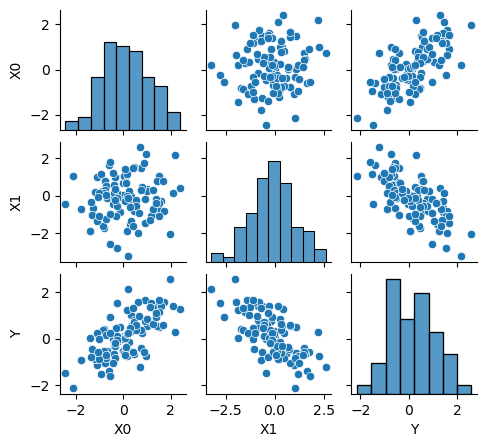

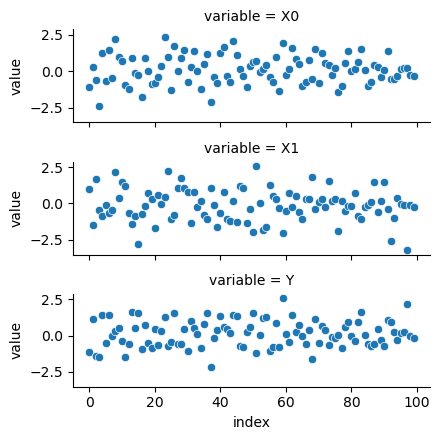

In [5]:
# now lets plot the data to check
data_df = pd.DataFrame({**{'X{}'.format(_): raw_X[:,_] for _ in np.arange(predictors)}, 'Y': raw_Y})
sns.pairplot(
    data_df,
    height=1.5, aspect=1.1
)
# plot as say a timeseries
g = sns.FacetGrid(data_df.reset_index().melt(id_vars='index'), row='variable', height=1.5, aspect=3)
g.map(sns.scatterplot,'index','value')
None

Scale (if necessary) and convert to jax arrays for feeding to NumPyro.

In [6]:
scaler_x = None
scaler_y = None

jnp_X = jnp.array(raw_X)
jnp_Y = jnp.array(raw_Y)

# 3. Define our model using NumPyro

We will fit our Bayesian Linear Regression using NumPyro. 
NumPyro is a probabilistic programming language which helps us to implement a sampling scheme for the paramaters in our model. You can read more about NumPyro [here](https://num.pyro.ai/en/stable/getting_started.html).

In [7]:
def linear_model(X,Y=None):
    '''
    Model description: Linear regression model
    y = X*beta + epsilon
    '''
    # Counts
    n_variables = X.shape[1]
    # prior for beta
    beta = numpyro.sample("beta", dist.Normal(0,2).expand([n_variables]).to_event(1))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    # Model
    mu = numpyro.deterministic("mu", jnp.matmul(X,beta))
    # and define the likelihood function
    return numpyro.sample("obs", dist.Normal(mu, sigma), obs=Y)

# 4. Prior checking
Now lets sample from out prior distributions, check what these look like with arviz. We will also check what our predictions look like from the priors to ensure we aren't assuming anything too silly.

In [8]:
# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)
# here take 100 samples from our priors and make predictions on x_log
prior_samples = Predictive(linear_model, num_samples=500)(
    rng_key_, X=jnp_X
)

# and put this into arviz for easy plotting
arviz_priors = az.from_numpyro(
    prior=prior_samples
)

# get the mean model prediciton and CI
mean_mu_prior = jnp.mean(arviz_priors.prior['mu'].values.squeeze(), axis=0)
hpdi_mu_prior = hpdi(arviz_priors.prior['mu'].values.squeeze(), ci)
hpdi_sim_prior = hpdi(arviz_priors.prior['obs'].values.squeeze(), ci)

arviz_priors

Inference data with groups:
	> prior

################################################################################
Priors


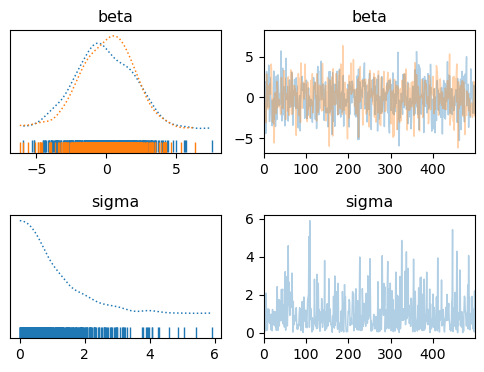

In [9]:
# and now plot the distributions and the simulated data
print('#'*80)
print('Priors')
priors_ax = az.plot_trace(
    arviz_priors.prior, 
    var_names=['beta','sigma'],
    figsize=(6,4),
    rug=True,
    combined=True,
    show=False
)
# make it readable
plt.subplots_adjust(hspace=0.5)
plt.show()

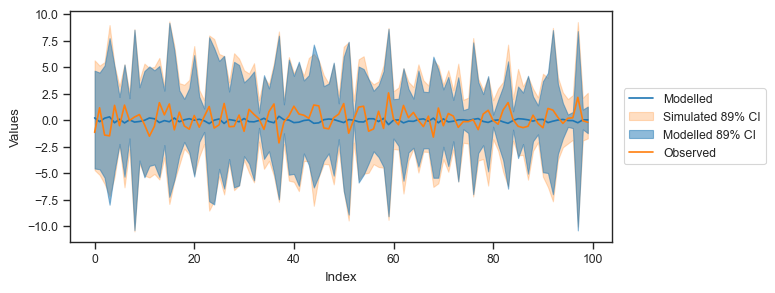

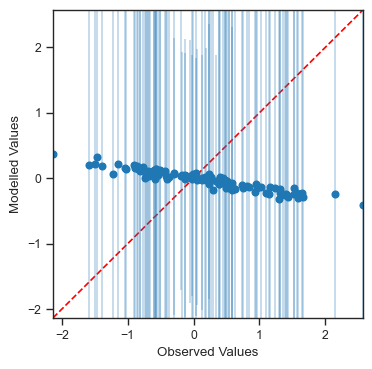

In [10]:
plot_prediction(data_df['Y'],mean_mu_prior,hpdi_mu_prior,hpdi_sim_prior,ci=ci)
plot_prediction_scatter(data_df['Y'],mean_mu_prior,hpdi_mu_prior,hpdi_sim_prior,ci=ci)
None

# 5. MCMC Sampling

We will use the No U-Turn Sampler (NUTS) to sample from our posterior distributions. This sampler is popular in many PPLs (Stan, pymc, pyro) and should do the job for us with our mere three parameters. We will sample `num_samples` times form the posterior, with `num_warmup` samples taken and discarded before we start proper.

Below is a generic setup that allows for the testing of multiple models via specifying `kernels_models`. 

In [11]:
# settings 
num_samples = 1000
num_warmup = 1000
num_chains = 4
max_tree = 10
save_bool = False # save to arviz netcdf
load_bool = False # load previous runs from arviz netcdf
extract_vars = ['beta','mu','sigma','obs'] # variables to extract from posterior_predictive
check_vars = [_ for _ in extract_vars if _ not in ['mu','obs']]

# JAX requires a key for random number generation
rng_key_ = random.PRNGKey(2101)

# define the sampler - No U-Turn Sampler (NUTS) for each model
# give a list with the NUTS sampler and the model
kernels_models = {
    'linear_model': [NUTS(linear_model,max_tree_depth=max_tree), linear_model]
}

# create storage
mcmc_outputs = {_: {} for _ in kernels_models.keys()}

if not load_bool:
    for kern_name, this_kern in kernels_models.items():
        print('Running model: {}'.format(kern_name))
        # now run the sampler for num_samples+burnin
        mcmc_obj = MCMC(this_kern[0], num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
        mcmc_obj.run(
            rng_key_,
            X = jnp_X,
            Y = jnp_Y
        )

        # get the samples which will form our posterior
        samples = mcmc_obj.get_samples()

        # get the samples for predictive uncertainty (our linear model + error)
        posterior_predictive = Predictive(
            this_kern[1], posterior_samples=samples, 
            return_sites=extract_vars
        )(rng_key_, X = jnp_X)

        # get named arvix object
        az_coords = {
            "covariates": ["X{}".format(_) for _ in range(jnp_X.shape[1])],
        }
        az_dims = {
            "beta": ["covariates"],
        }
        # create an arviz object
        arviz_posterior = az.from_numpyro(
            mcmc_obj,
            posterior_predictive=posterior_predictive,
            prior=prior_samples,
            coords=az_coords,
            dims=az_dims
        )

        # get the mean model prediciton and use hpdi 
        # to compute the credible intervals corresponding to ci
        mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
            arviz_posterior, ci=ci, y_scaler=scaler_y
        )
        
        mcmc_outputs[kern_name] = {
            'arviz_posterior': arviz_posterior,
            'mean_mu': mean_mu,
            'hpdi_mu': hpdi_mu,
            'hpdi_sim': hpdi_sim
        }
        # and save
        if save_bool:
            arviz_posterior.to_netcdf(arviz_savepath.format(kern_name))
else:
    # load the arviz objects
    for this_mod in kernels_models.keys():
        tmp_arviz = az.from_netcdf(arviz_savepath.format(this_mod))
        # calculate mean_mu, hpdi_mu and hpdi_sim
        mean_mu, hpdi_mu, hpdi_sim = calc_mean_hpdi(
            tmp_arviz, ci=ci, y_scaler=scaler_y
        ) 
        # and store
        mcmc_outputs[this_mod] = {
            'arviz_posterior': tmp_arviz,
            'mean_mu': mean_mu,
            'hpdi_mu': hpdi_mu,
            'hpdi_sim': hpdi_sim
        }

Running model: linear_model


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Examine MCMC diagnostics as needed to check for convergence.

In [12]:
this_model = 'linear_model'
az.rhat(mcmc_outputs[this_model]['arviz_posterior'],var_names=check_vars)

<xarray.Dataset>
Dimensions:     (covariates: 2)
Coordinates:
  * covariates  (covariates) <U2 'X0' 'X1'
Data variables:
    beta        (covariates) float64 0.9999 1.001
    sigma       float64 1.001

## 5.1 MCMC Results

Plot the posterior distributions for our parameters and check for differences between the parameters for different groups. See poster for further discussion.

################################################################################
Posterior


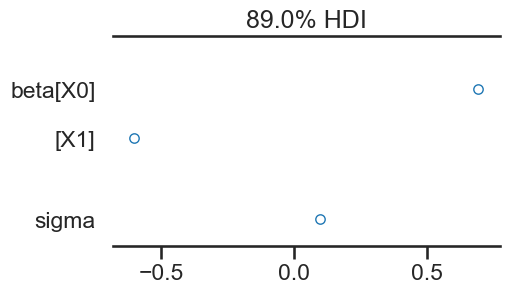

In [13]:
this_model = 'linear_model'
print('#'*80)
print('Posterior')
sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,6))
ax1 = plt.subplot(211)
az.plot_forest(
    mcmc_outputs[this_model]['arviz_posterior'],
    var_names=check_vars,
    hdi_prob=ci,
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
None

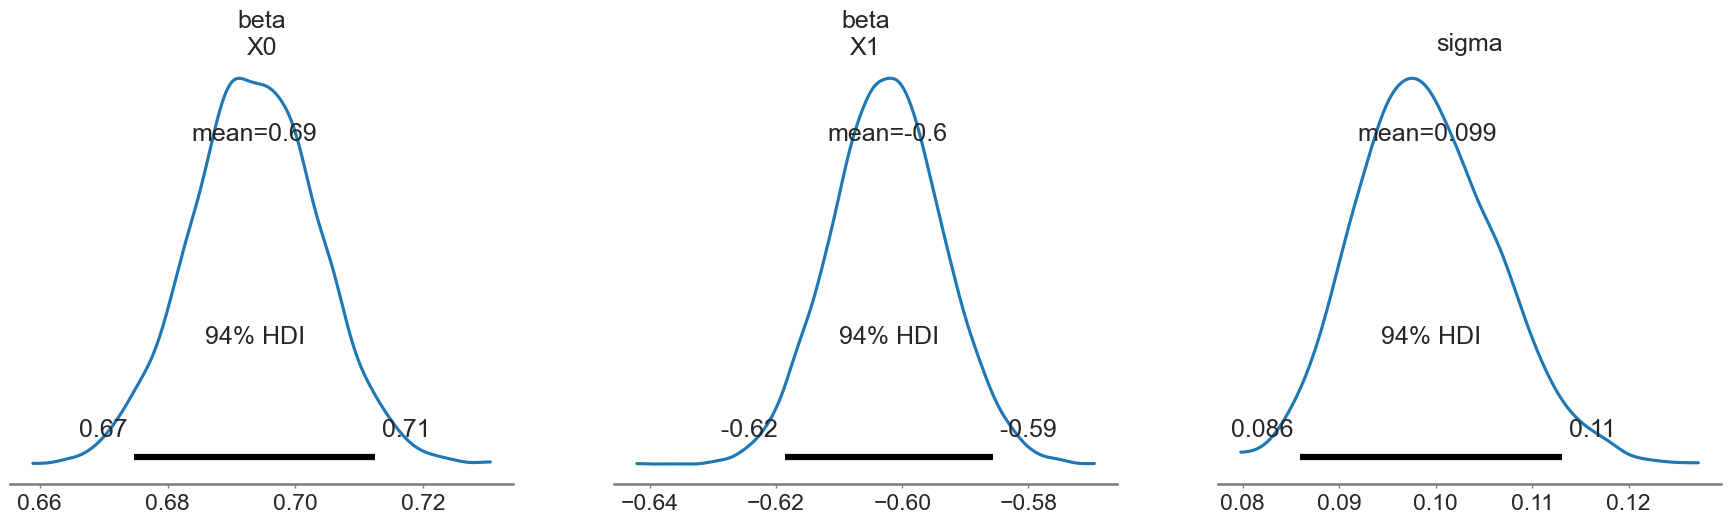

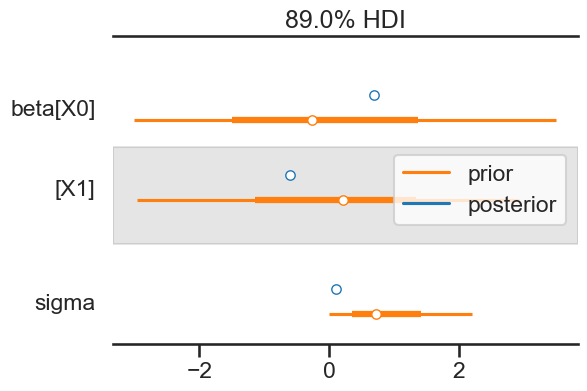

In [14]:
# Plot the posteriors
az.plot_posterior(mcmc_outputs[this_model]['arviz_posterior'], var_names=check_vars)
# Compare to priors
az.plot_forest(
    [
        mcmc_outputs[this_model]['arviz_posterior'].posterior,
        mcmc_outputs[this_model]['arviz_posterior'].prior
    ],
    combined=True,
    hdi_prob=ci,
    model_names=['posterior','prior'],
    var_names=check_vars,
    figsize=(6,4)
)
None

# 6. Plot the results

We can now plot our model predictions with uncertainty for our selected credible interval (`ci`) - say 89%. Notice that we plot two uncertainty bands, the first is the credible interval for our linear model (blue bands). Essentially, what are range of parameter values that our regression fit could have. 

However, we also have the $\sigma$ parameter. The predictive uncertainty (credible interval given by the orange bands) incorporates model uncertainty and the error ($\epsilon$) which describes our data (which we have assumed to be of the form $\mathcal{N}(0,\sigma)$). 

Here we are simulating possible values of actual data points, as opposed to just the range of possible regression predictions. This range reflects the shoreline change we could expect for a new event if measured by Coastsat data, rather than our modelled prediction of actual shoreline change. These bands should include approximately 89% of our data points, i.e. approximately matching the `ci` we have chosen.

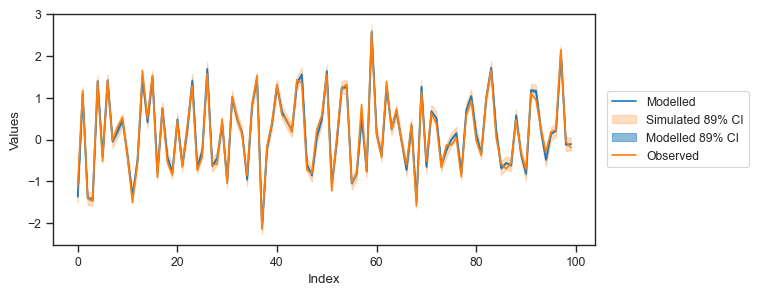

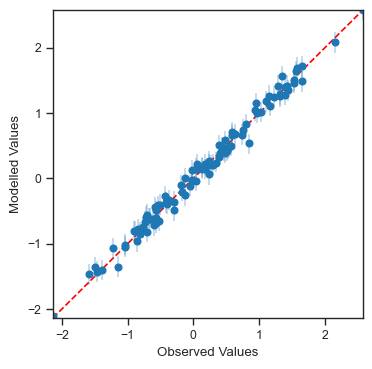

In [15]:
this_model = 'linear_model'

plot_prediction(
    data_df['Y'],
    mcmc_outputs[this_model]['mean_mu'],
    mcmc_outputs[this_model]['hpdi_mu'],
    mcmc_outputs[this_model]['hpdi_sim'],
    ci=ci
)
plot_prediction_scatter(
    data_df['Y'],
    mcmc_outputs[this_model]['mean_mu'],
    mcmc_outputs[this_model]['hpdi_mu'],
    mcmc_outputs[this_model]['hpdi_sim'],
    ci=ci
)
None